In [75]:
rm(list = ls())
setwd("~/tsang_project/sc_annotation/")

In [76]:
library(SeuratDisk)
library(Seurat)
library(tidyverse)
#library(NHANES)    # demo data 
library(randomForest) # power RF training 
library(caret) # train test partition 
library(yardstick) # model metric
library(pheatmap)

In [77]:
### data load & preprocess

# load data
seurat_adt = LoadH5Seurat("./data/sorted_cells.adt.raw.h5Seurat", verbose = FALSE)

# log1p normalize -- as in the paper
seurat_adt = NormalizeData(seurat_adt, normalization.method = "LogNormalize", scale.factor = 1e3)

# extract expr matrix & reformat
expr_matrix = t(as.matrix(seurat_adt@assays$ADT@data))
expr_df = data.frame(expr_matrix) 
expr_df = mutate(expr_df, cell_type = factor(str_split(rownames(expr_df), pattern='\\.', simplify = TRUE)[,4])) # include class labels 

# create rank matrix 
rank_df = data.frame(t(apply(expr_matrix, 1, function (x) {rank(x, ties.method = "average")})))
rank_df = mutate(rank_df, cell_type = factor(str_split(rownames(rank_df), pattern='\\.', simplify = TRUE)[,4]))

Validating h5Seurat file



In [78]:
head(rank_df, 5)

,Hu.CD140b..PDGFR.,Hu.CD314..NKG2D.,Annexin.A1,CD230..Prion.,Human.Podoplanin,human.mouse.rat.CD278..ICOS.,human.mouse.CD49f,human.mouse.integrin.7,B7.H4,C5L2,⋯,TNF.,TSLPR..TSLP.R.,TSPAN33..BAAM.,VEGFR.3..FLT.4.,XCR1,mast.cell.tryptase,mouse.human.CD44,mouse.human.CD45R.B220,mouse.human.Mac.2..Galectin.3.,cell_type
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
CAGATTGCAGCATACT.0.HTO2.cd4_cm,171.5,156.5,81.5,264.0,125.5,244.5,253.0,81.5,81.5,81.5,⋯,81.5,214.5,184.0,229.5,184.0,125.5,81.5,30.0,81.5,cd4_cm
CATTTCACAGGTTACT.0.HTO8.monocyte,33.5,127.5,33.5,252.0,91.0,150.5,33.5,91.0,91.0,33.5,⋯,33.5,91.0,127.5,201.5,91.0,33.5,172.5,33.5,33.5,monocyte
ATTCTACCATATGGCT.0.HTO2.cd4_cm,111.5,171.5,42.5,262.0,234.0,256.0,248.0,171.5,42.5,111.5,⋯,111.5,149.0,111.5,217.5,204.5,42.5,149.0,42.5,42.5,cd4_cm
TGGGATTCAAAGCTCT.0.HTO6.cd8_em,143.5,143.5,38.0,263.5,143.5,236.5,192.0,232.5,38.0,100.0,⋯,38.0,143.5,173.0,215.0,243.5,38.0,215.0,38.0,38.0,cd8_em
CTTCAATAGCATGCAG.0.HTO5.cd8_cm,110.5,231.0,150.0,263.0,110.5,211.5,197.5,178.5,43.5,150.0,⋯,43.5,110.5,178.5,211.5,43.5,43.5,110.5,43.5,110.5,cd8_cm


### Train RF Flat

Reference: [Multi-class Classifier using randomForest in R](https://rpubs.com/jkylearmstrong/RF_Imputation_Multi_class)

In [4]:
set.seed(72)

entry = 'expr'

if (entry == 'expr') {
    data = expr_df
} else {
    data = rank_df
}
data[1:2,1:5]

cat('\n--- Training w/', entry, 'data ---\n')

### train-test split

# this beautiful method keeps partition within each class
train_idx = createDataPartition(data$cell_type, p = .6, list=FALSE, times=1)

TRAIN <- data[train_idx, ]
TEST  <- data[-train_idx, ]

# cat('- All: \n')
# table(data$cell_type) / sum(table(data$cell_type)); cat('\n')
# cat('- TRAIN: \n')
# table(TRAIN$cell_type) / sum(table(TRAIN$cell_type)); cat('\n')
# cat('- TEST: \n')
# table(TEST$cell_type) / sum(table(TEST$cell_type)); cat('\n')

### train model 

train_ctrl = trainControl(method = 'cv', 
                      number = 10,
                      search = 'random')

toc <- Sys.time()
model_rf <- train(cell_type ~ .,
                   data = TRAIN,
                   method = "rf", # this will use the randomForest::randomForest function
                   metric = "Accuracy", # which metric should be optimized for 
                   trControl = train_ctrl,
                   # options to be passed to randomForest
                   ntree = 500,
                   keep.forest=TRUE,
                   importance=TRUE) 
tic <- Sys.time()

tic - toc

cat('\n-- Model summary:\n')
model_rf

### test model

probs <- predict(model_rf, TEST, 'prob')
class <- predict(model_rf, TEST, 'raw')
TEST.scored <- cbind(TEST, probs, class)

cm <- conf_mat(TEST.scored, truth = cell_type, class)
cat('\n-- Test summary:\n')
summary(cm)

### save model

if (entry == 'expr') {
    model_expr       = model_rf
    TEST.scored_expr = TEST.scored
} else {
    model_rank       = model_rf
    TEST.scored_rank = TEST.scored
}

cat('\n--- Analysis FINISHED w/', entry, 'data ---\n')
    

,Hu.CD140b..PDGFR.,Hu.CD314..NKG2D.,Annexin.A1,CD230..Prion.,Human.Podoplanin
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CAGATTGCAGCATACT.0.HTO2.cd4_cm,1.31203,1.1103031,0.5178565,3.823763,0.8573269
CATTTCACAGGTTACT.0.HTO8.monocyte,0.00000,0.7603161,0.0000000,2.863047,0.4507419



--- Training w/ expr data ---


Time difference of 41.46803 mins


-- Model summary:


Random Forest 

6294 samples
 265 predictor
   8 classes: 'cd4_cm', 'cd4_em', 'cd4_n', 'cd8_cm', 'cd8_em', 'cd8_emra', 'cd8_n', 'monocyte' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 5665, 5665, 5664, 5664, 5664, 5665, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   80   0.9448727  0.9365525
  172   0.9432829  0.9347217
  241   0.9418535  0.9330730

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 80.


-- Test summary:


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9463391
kap,multiclass,0.9382410
sens,macro,0.9427441
spec,macro,0.9923098
ppv,macro,0.9440931
npv,macro,0.9923427
mcc,multiclass,0.9382697
j_index,macro,0.9350539
bal_accuracy,macro,0.9675270



--- Analysis FINISHED w/ expr data ---


In [79]:
?train

train {caret},R Documentation
x,"For the default method, x is an object where samples are in rows and features are in columns. This could be a simple matrix, data frame or other type (e.g. sparse matrix) but must have column names (see Details below). Preprocessing using the preProcess argument only supports matrices or data frames. When using the recipe method, x should be an unprepared recipe object that describes the model terms (i.e. outcome, predictors, etc.) as well as any pre-processing that should be done to the data. This is an alternative approach to specifying the model. Note that, when using the recipe method, any arguments passed to preProcess will be ignored. See the links and example below for more details using recipes."
...,Arguments passed to the classification or regression routine (such as randomForest). Errors will occur if values for tuning parameters are passed here.
y,A numeric or factor vector containing the outcome for each sample.
method,A string specifying which classification or regression model to use. Possible values are found using names(getModelInfo()). See http://topepo.github.io/caret/train-models-by-tag.html. A list of functions can also be passed for a custom model function. See http://topepo.github.io/caret/using-your-own-model-in-train.html for details.
preProcess,"A string vector that defines a pre-processing of the predictor data. Current possibilities are ""BoxCox"", ""YeoJohnson"", ""expoTrans"", ""center"", ""scale"", ""range"", ""knnImpute"", ""bagImpute"", ""medianImpute"", ""pca"", ""ica"" and ""spatialSign"". The default is no pre-processing. See preProcess and trainControl on the procedures and how to adjust them. Pre-processing code is only designed to work when x is a simple matrix or data frame."
weights,A numeric vector of case weights. This argument will only affect models that allow case weights.
metric,"A string that specifies what summary metric will be used to select the optimal model. By default, possible values are ""RMSE"" and ""Rsquared"" for regression and ""Accuracy"" and ""Kappa"" for classification. If custom performance metrics are used (via the summaryFunction argument in trainControl, the value of metric should match one of the arguments. If it does not, a warning is issued and the first metric given by the summaryFunction is used. (NOTE: If given, this argument must be named.)"
maximize,A logical: should the metric be maximized or minimized?
trControl,"A list of values that define how this function acts. See trainControl and http://topepo.github.io/caret/using-your-own-model-in-train.html. (NOTE: If given, this argument must be named.)"
tuneGrid,"A data frame with possible tuning values. The columns are named the same as the tuning parameters. Use getModelInfo to get a list of tuning parameters for each model or see http://topepo.github.io/caret/available-models.html. (NOTE: If given, this argument must be named.)"


In [5]:
entry = 'rank'

if (entry == 'expr') {
    data = expr_df
} else {
    data = rank_df
}
data[1:2,1:5]

cat('\n--- Training w/', entry, 'data ---\n')

### train-test split

# this beautiful method keeps partition within each class
train_idx = createDataPartition(data$cell_type, p = .6, list=FALSE, times=1)

TRAIN <- data[train_idx, ]
TEST  <- data[-train_idx, ]

# cat('- All: \n')
# table(data$cell_type) / sum(table(data$cell_type)); cat('\n')
# cat('- TRAIN: \n')
# table(TRAIN$cell_type) / sum(table(TRAIN$cell_type)); cat('\n')
# cat('- TEST: \n')
# table(TEST$cell_type) / sum(table(TEST$cell_type)); cat('\n')

### train model 

train_ctrl = trainControl(method = 'cv', 
                      number = 10,
                      search = 'random')

toc <- Sys.time()
model_rf <- train(cell_type ~ .,
                   data = TRAIN,
                   method = "rf", # this will use the randomForest::randomForest function
                   metric = "Accuracy", # which metric should be optimized for 
                   trControl = train_ctrl,
                   # options to be passed to randomForest
                   ntree = 500,
                   keep.forest=TRUE,
                   importance=TRUE) 
tic <- Sys.time()

tic - toc

cat('\n-- Model summary:\n')
model_rf

### test model

probs <- predict(model_rf, TEST, 'prob')
class <- predict(model_rf, TEST, 'raw')
TEST.scored <- cbind(TEST, probs, class)

cm <- conf_mat(TEST.scored, truth = cell_type, class)
cat('\n-- Test summary:\n')
summary(cm)

### save model

if (entry == 'expr') {
    model_expr       = model_rf
    TEST.scored_expr = TEST.scored
} else {
    model_rank       = model_rf
    TEST.scored_rank = TEST.scored
}

cat('\n--- Analysis FINISHED w/', entry, 'data ---\n')
    

,Hu.CD140b..PDGFR.,Hu.CD314..NKG2D.,Annexin.A1,CD230..Prion.,Human.Podoplanin
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CAGATTGCAGCATACT.0.HTO2.cd4_cm,171.5,156.5,81.5,264,125.5
CATTTCACAGGTTACT.0.HTO8.monocyte,33.5,127.5,33.5,252,91.0



--- Training w/ rank data ---


Time difference of 44.07685 mins


-- Model summary:


Random Forest 

6294 samples
 265 predictor
   8 classes: 'cd4_cm', 'cd4_em', 'cd4_n', 'cd8_cm', 'cd8_em', 'cd8_emra', 'cd8_n', 'monocyte' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 5666, 5662, 5665, 5666, 5666, 5663, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   36   0.9466150  0.9385516
   41   0.9474094  0.9394675
  106   0.9469335  0.9389231

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 41.


-- Test summary:


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9415693
kap,multiclass,0.9327433
sens,macro,0.9377722
spec,macro,0.9916051
ppv,macro,0.9401444
npv,macro,0.9916601
mcc,multiclass,0.9328041
j_index,macro,0.9293773
bal_accuracy,macro,0.9646886



--- Analysis FINISHED w/ rank data ---


In [7]:
## save model 
save(model_expr, TEST.scored_expr,model_rank,TEST.scored_rank,
     file = "./data/RF_flat-sorted_cells-expr_rank-train1CV10.RData")

### Evaluate model performance

In [7]:
load("./data/RF_flat-sorted_cells-expr_rank-train1CV10.RData")

          Truth
Prediction cd4_cm cd4_em cd4_n cd8_cm cd8_em cd8_emra cd8_n monocyte
  cd4_cm      370     16    16      0      0        0     0        2
  cd4_em       24    574     0      0      1        0     0        1
  cd4_n        19      0   436      0      0        0     0        2
  cd8_cm        1      0     0    399     17        0    12        0
  cd8_em        0      0     0     40    680       21     0        0
  cd8_emra      0      0     1      1     31      385     8        0
  cd8_n         0      0     0      6      0        6   462        0
  monocyte      0      0     0      0      0        0     0      662


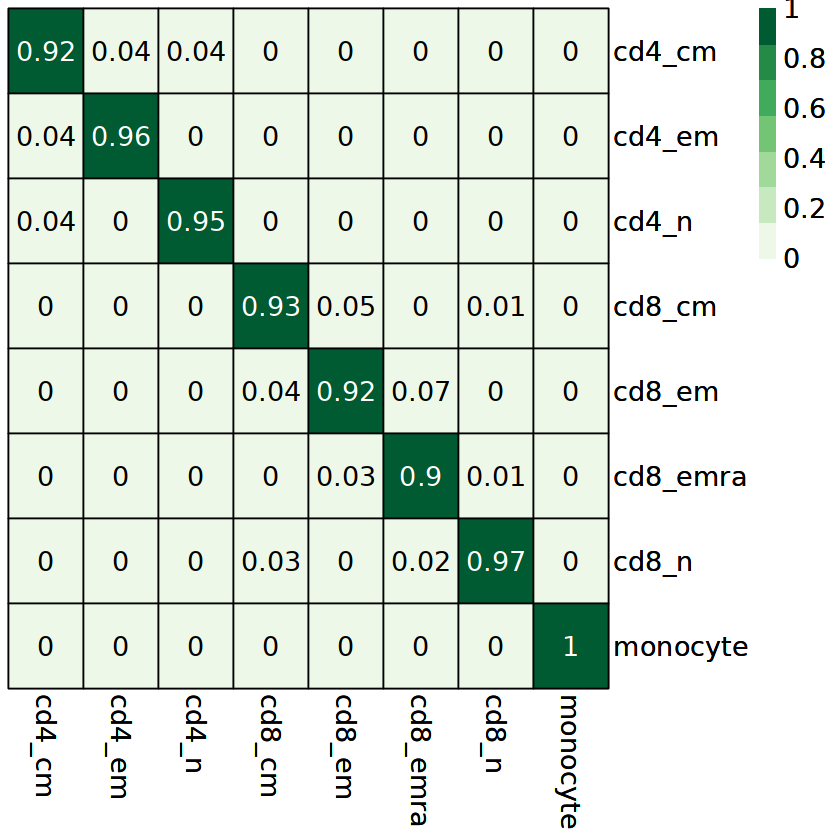

In [73]:
## evaluate accuracy
plot_confusion(TEST.scored_expr)

          Truth
Prediction cd4_cm cd4_em cd4_n cd8_cm cd8_em cd8_emra cd8_n monocyte
  cd4_cm      366     11    11      0      0        0     0        2
  cd4_em       25    575     2      0      0        0     0        0
  cd4_n        23      0   440      0      0        0     0        4
  cd8_cm        0      0     0    395     18        0     7        0
  cd8_em        0      4     0     41    671       26     0        1
  cd8_emra      0      0     0      1     36      374     8        0
  cd8_n         0      0     0      9      4       12   467        0
  monocyte      0      0     0      0      0        0     0      660


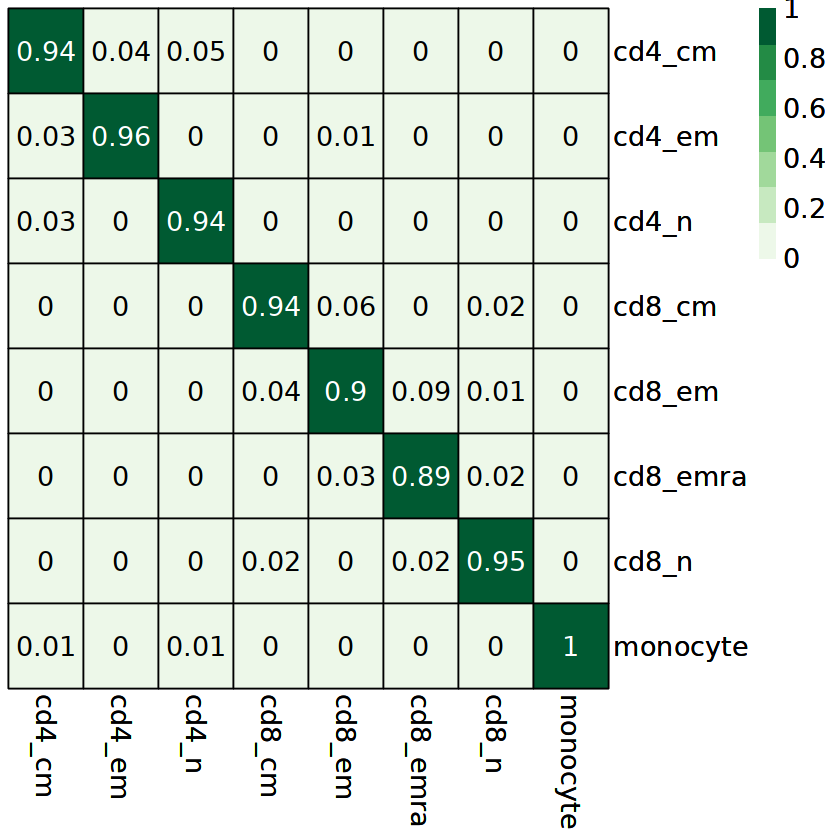

In [72]:
plot_confusion(TEST.scored_rank)

In [71]:
# helper functions

#calcualte_f1

plot_confusion = function (test_df) {
    library(pheatmap)
    library(RColorBrewer)
    library(viridis)

    confusion = conf_mat(test_df, truth=cell_type, class)
    print(confusion)

    labels = colnames(confusion$table)
    mat = matrix(confusion$table, nrow = length(labels))
    mat = apply(mat, 1, function (x) {x / sum(x)})
    rownames(mat)=labels
    colnames(mat)=labels

    p=pheatmap(mat, cluster_cols=F, cluster_rows=F, fontsize = 16, 
               display_numbers = round(mat,2), fontsize_number=16,
               number_color = ifelse(row(mat) == col(mat), 'white', 'black'),
               border_color = "black",
               color=brewer.pal(n = nrow(mat)-1, name = "Greens"))
    print(p)
}

In [74]:
varImp(model_expr)

rf variable importance

  variables are sorted by maximum importance across the classes
  only 20 most important variables shown (out of 265)

                            cd4_cm  cd4_em  cd4_n cd8_cm cd8_em cd8_emra  cd8_n
CD62L                      68.1667 100.000 11.676 77.295 87.634   80.174 33.780
CD45RA                     26.4898  14.978 59.685 56.864 43.751   63.743 63.119
CD4                        14.2752  16.276 16.185 12.896 21.813   12.809 14.539
CD8                        19.8573  12.901 15.744 16.534 18.247   13.095 16.703
CLEC12A                    10.7116  11.767 11.047 10.331 11.715   11.148 11.198
CD36                       10.6478   9.832  9.557  9.413  9.107    8.962  9.027
CD244..2B4.                 6.3403   4.767 11.306  3.980  5.327    8.608  7.379
CD95..Fas.                  7.0514   9.169  9.313  8.436  8.188    9.207 11.165
CD45RO                      7.6176   8.054 10.340  8.960  7.776   10.874  9.389
CD155..PVR.                 7.9577   7.101  7.030  7.233 